pip install torch

In [3]:
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

## Data Retrieval

In [4]:
#@title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

23589 neurons in response to 360 stimuli


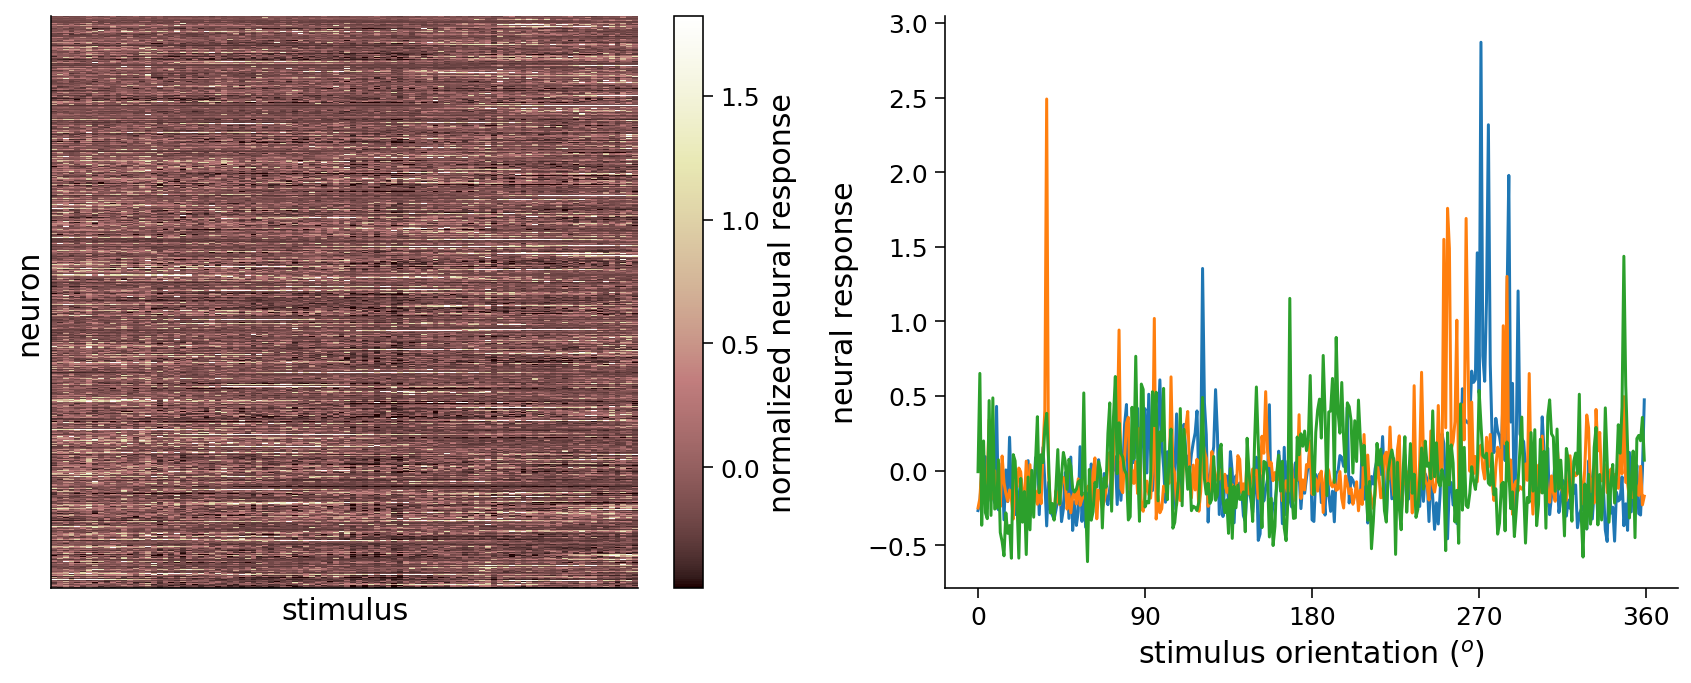

In [14]:
#@title

#@markdown Execute this cell to load and visualize data

# Load data
resp_all, stimuli_all = load_data()  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

print(f'{n_neurons} neurons in response to {n_stimuli} stimuli')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:100, :].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

plt.tight_layout()

In [15]:
#@title
#@markdown Execute this cell to split into training and test sets

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

## Figure Settings

In [5]:
#@title Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

## Helper Functions

In [6]:
#@title Helper Functions

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontanous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def plot_data_matrix(X, ax):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1), vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])


def identityLine():
  """
  Plot the identity line y=x
  """
  ax = plt.gca()
  lims = np.array([ax.get_xlim(), ax.get_ylim()])
  minval = lims[:, 0].min()
  maxval = lims[:, 1].max()
  equal_lims = [minval, maxval]
  ax.set_xlim(equal_lims)
  ax.set_ylim(equal_lims)
  line = ax.plot([minval, maxval], [minval, maxval], color="0.7")
  line[0].set_zorder(-1)

def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

def stimulus_class(ori, n_classes):
  """Get stimulus class from stimulus orientation

  Args:
    ori (torch.Tensor): orientations of stimuli to return classes for
    n_classes (int): total number of classes

  Returns:
    torch.Tensor: 1D tensor with the classes for each stimulus

  """
  bins = np.linspace(0, 360, n_classes + 1)
  return torch.tensor(np.digitize(ori.squeeze(), bins)) - 1  # minus 1 to accomodate Python indexing

def plot_decoded_results(train_loss, test_labels, predicted_test_labels):
  """ Plot decoding results in the form of network training loss and test predictions

  Args:
    train_loss (list): training error over iterations
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  # Plot results
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  # Plot the training loss over iterations of GD
  ax1.plot(train_loss)

  # Plot true stimulus orientation vs. predicted class
  ax2.plot(stimuli_test.squeeze(), predicted_test_labels, '.')

  ax1.set_xlim([0, None])
  ax1.set_ylim([0, None])
  ax1.set_xlabel('iterations of gradient descent')
  ax1.set_ylabel('negative log likelihood')
  ax2.set_xlabel('true stimulus orientation ($^o$)')
  ax2.set_ylabel('decoded orientation bin')
  ax2.set_xticks(np.linspace(0, 360, n_classes + 1))
  ax2.set_yticks(np.arange(n_classes))
  class_bins = [f'{i * 360 / n_classes: .0f}$^o$ - {(i + 1) * 360 / n_classes: .0f}$^o$' for i in range(n_classes)]
  ax2.set_yticklabels(class_bins);

  # Draw bin edges as vertical lines
  ax2.set_ylim(ax2.get_ylim())  # fix y-axis limits
  for i in range(n_classes):
    lower = i * 360 / n_classes
    upper = (i + 1) * 360 / n_classes
    ax2.plot([lower, lower], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)
    ax2.plot([upper, upper], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)

  plt.tight_layout()

## Create Pytorch Class

In [11]:
class DeepNet(nn.Module):
    """Deep Network with one hidden layer

    Args:
        n_inputs (int): number of input units
        n_hidden (int): number of units in hidden layer

      Attributes:
        in_layer (nn.Linear): weights and biases of input layer
        out_layer (nn.Linear): weights and biases of output layer

    """
    
    def __init__(self, n_inputs, n_hidden):
        super().__init__()  # needed to invoke the properties of the parent class nn.Module
        self.in_layer = nn.Linear(n_inputs, n_hidden)  # neural activity --> hidden units
        self.out_layer = nn.Linear(n_hidden, 1)        # hidden units --> output
        
    def forward(self, r):
        """Decode stimulus orientation from neural responses

        Args:
          r (torch.Tensor): vector of neural responses to decode, must be of
            length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
            containing n_stimuli vectors of neural responses

        Returns:
          torch.Tensor: network outputs for each input provided in r. If
            r is a vector, then y is a 1D tensor of length 1. If r is a 2D
            tensor then y is a 2D tensor of shape n_stimuli x 1.
            h = self.in_layer()
         """
        
        h = self.in_layer(r)  # hidden representation
        y = self.out_layer(h)
        
        return y

In [16]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
deep_net = DeepNet(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = deep_net.forward(r)  # compute output from network, equivalent to net.forward(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.08 degrees
true orientation: 139.00 degrees


## Include Activation Function

- Use Rectified Linear Unit

In [17]:
class DeepNetReLU(nn.Module):

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    ############################################################################
    ## TO DO for students: write code for computing network output using a
    ## rectified linear activation function for the hidden units
    # Fill out function and remove
    # raise NotImplementedError("Student exercise: complete DeepNetReLU forward")
    ############################################################################

    h = torch.relu(self.in_layer(r))
    y = self.out_layer(h)

    return y


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)

# Uncomment to test your class

# Initialize deep network with M=20 hidden units and uncomment lines below
net = DeepNetReLU(n_neurons, 1)

# Decode orientation from these neural responses using initialized network
# net(r) is equivalent to net.forward(r)
out = net.forward(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.87 degrees
true orientation: 139.00 degrees


## Compute Mean-Squared Error

In [18]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=20 hidden units
net = DeepNetReLU(n_neurons, 20)

# Get neural responses to first 20 stimuli in the data set
r, ori = get_data(20, resp_train, stimuli_train)

# Decode orientation from these neural responses
out = net(r)

###################################################
## TO DO for students: evaluate mean squared error
###################################################

# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
loss_fn = nn.MSELoss()

# Evaluate mean squared error
loss = loss_fn(out, ori)

# Uncomment once above is filled in
print('mean squared error: %.2f' % loss)

mean squared error: 42943.75


---
### Section 3.2: Optimization with gradient descent

Our goal is now to modify the weights to make the mean squared error loss $L$ as small as possible over the whole data set. To do this, we'll use the **gradient descent (GD)** algorithm, which consists of iterating three steps:
1. **Evaluate the loss** on the training data,
```
out = net(train_data)
loss = loss_fn(out, train_labels)
```
where `train_data` are the network inputs in the training data (in our case, neural responses), and `train_labels` are the target outputs for each input (in our case, true stimulus orientations).
2. **Compute the gradient of the loss** with respect to each of the network weights. In PyTorch, we can do this with one line of code:
```
loss.backward()
```
This command tells PyTorch to compute the gradients of the quantity stored in the variable `loss` with respect to each network parameter using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). These gradients are then stored behind the scenes (see appendix for more details).
3. **Update the network weights** by descending the gradient. In Pytorch, we can do this using built-in optimizers. We'll use the `optim.SGD` optimizer (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)) which updates parameters along the negative gradient, scaled by a learning rate (see appendix for details). To initialize this optimizer, we have to tell it
  * which parameters to update, and
  * what learning rate to use

  For example, to optimize *all* the parameters of a network `net` using a learning rate of .001, the optimizer would be initialized as follows
  ```
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where `.parameters()` is a method of the `nn.Module` class that returns a [Python generator object](https://wiki.python.org/moin/Generators) over all the parameters of that `nn.Module` class (in our case, $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$).
  
  After computing all the parameter gradients in step 2, we can then update each of these parameters using the `.step()` method of this optimizer,
  ```
  optimizer.step()
  ```
  This single line of code will extract all the gradients computed with `.backward()` and execute the SGD updates for each parameter given to the optimizer. Note that this is true no matter how big/small the network is, allowing us to use the same two lines of code to perform the gradient descent updates for any deep network model built using PyTorch.

Finally, an important detail to remember is that the gradients of each parameter need to be cleared before calling `.backward()`, or else PyTorch will try to accumulate gradients across iterations. This can again be done using built-in optimizers via the method `zero_grad()`, as follows:
```
optimizer.zero_grad()
```

Putting all this together, each iteration of the GD algorith will contain a block of code that looks something like this:
```
Get outputs from network
Evaluate loss

# Compute gradients
optimizer.zero_grad()  # clear gradients
loss.backward()

# Update weights
optimizer.step()
```

In the next exercise, we'll give you a code skeleton for implementing the GD algorithm. Your job will be to fill in the blanks.

For the mathematical details of the GD algorithm, see the appendix. Note, in particular, that here we using the gradient descent algorithm, rather than the more commonly used *stochastic* gradient descent algorithm. See the appendix for a more detailed discussion of how these differ and when one might need to use the stochastic variant.

iteration 10/50 | loss: 11225.866
iteration 20/50 | loss: 796.539
iteration 30/50 | loss: 449.642
iteration 40/50 | loss: 285.460
iteration 50/50 | loss: 186.747


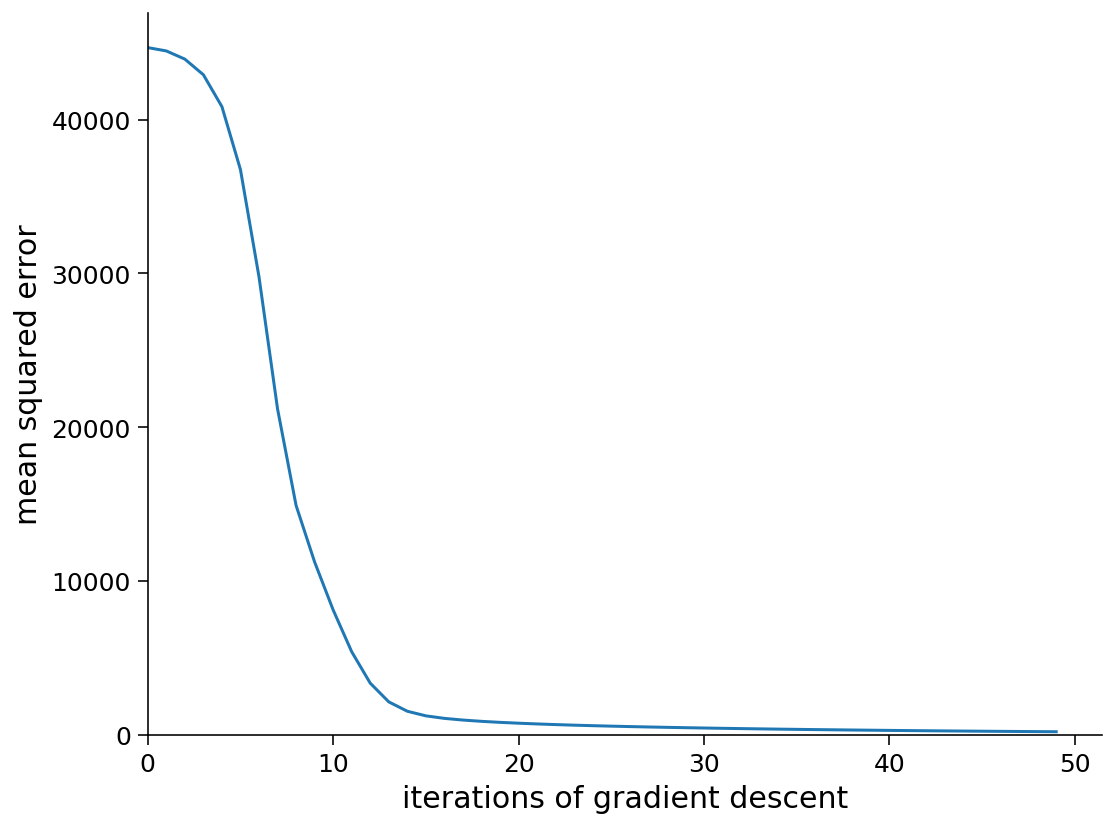

In [19]:
def train(net, loss_fn, train_data, train_labels, n_iter=50, learning_rate=1e-4):
  """Run gradient descent to opimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    n_iter (int): number of iterations of gradient descent to run
    learning_rate (float): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  track_loss = []

  # Loop over epochs (cf. appendix)
  for i in range(n_iter):

    ######################################################################
    ## TO DO for students: fill in missing code for GD iteration
    # raise NotImplementedError("Student exercise: write code for GD iterations")
    ######################################################################

    # Evaluate loss using loss_fn
    out = net.forward(train_data)  # compute network output from inputs in train_data
    loss = loss_fn(out, train_labels)  # evaluate loss function

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    track_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_iter // 5) == 0:
      print(f'iteration {i + 1}/{n_iter} | loss: {loss.item():.3f}')

return track_loss

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network
net = DeepNetReLU(n_neurons, 20)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run GD on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plt.plot(train_loss)
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('iterations of gradient descent')
plt.ylabel('mean squared error')
plt.show()